# Scale: NSIDE = 2048

### Notebook to prepare the full north dataset used for training of different models, combining different code throughout this repo

In [48]:
# Importing Libraries

import pandas as pd
import healpy as hp
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Maps at 2048 NORTH


In [49]:
NSIDE = 2048
NPIX = hp.nside2npix(NSIDE)
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

In [50]:
# Import Northern Galaxies and Drop NAS and DUPLS
df_north = pd.read_csv('../../../bricks_data/galaxy_catalogue_north.csv',
                       dtype={'BrickID': 'int32', 'LRG': 'int8', 'ELG': 'int8', 'QSO': 'int8'})
df_north = df_north.drop_duplicates()
# Removing all Lines with Nan that were added to ensure that all bricks are stored
df_north = df_north.dropna(axis=0, inplace=False, how='any')

### 2. Get Galaxy Count per 2048 Healpy Pixel

### NORTH

In [51]:
# LRG
df_LRG = df_north[df_north["LRG"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

LRG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block
id_density = np.stack((unique, counts), axis=1)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)

Mean LRGs per Pixel: 1.4535700059544587


In [52]:
# elg
df_ELG = df_north[df_north["ELG"] == 1]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)
ELG_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)
mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
id_density = np.stack((unique, counts), axis=1)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

Mean ELGs per Pixel: 2.347347050336317


In [53]:
df_QSO = df_north[df_north["QSO"] == 1]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)
QSO_pixel_indices = hp.ang2pix(NSIDE, theta, phi)
# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)
mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)

id_density = np.stack((unique, counts), axis=1)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

Mean QSOs per Pixel: 2.7237364970237756


In [54]:
df_north = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df_north = pd.merge(df_north, df_qso, how='outer', on='pixel_id')
print(df_lrg.shape, df_elg.shape, df_qso.shape, df_north.shape)

df_north.fillna(axis=0, value=0, inplace=True)

(2435150, 2) (5301401, 2) (5601728, 2) (6237002, 4)


In [55]:
df_north = df_north.astype(int)


# Getting Exposure Densities across pixels

In [56]:

with open('../../../bricks_data/pixel2ccd_2048_non_inclusive.pickle', 'rb') as f:
    pixel2ccd_dict = pickle.load(f)
    f.close()



In [57]:
df_north = df_north.astype(int)
df_north.head()



,pixel_id,lrg,elg,qso
0,104818,1,2,0
1,104823,1,1,1
2,104838,1,0,1
3,104839,1,1,0
4,104849,1,1,0


In [58]:
pix_ids = df_north.pixel_id.to_numpy()
exp_len = np.zeros(len(pix_ids))
print(pix_ids)
for i, pix in enumerate(pix_ids):
    exp_len[i] = len(pixel2ccd_dict[pix])

print(exp_len)

df_north['exposures'] = exp_len

df_north.head()

[  104818   104823   104838 ... 25850742 25850747 25857913]
[ 4.  1.  1. ... 36. 42. 26.]


,pixel_id,lrg,elg,qso,exposures
0,104818,1,2,0,4.0
1,104823,1,1,1,1.0
2,104838,1,0,1,1.0
3,104839,1,1,0,4.0
4,104849,1,1,0,1.0


In [59]:
df_north = df_north.astype(int)


0.0 180.0 -180.0 180.0


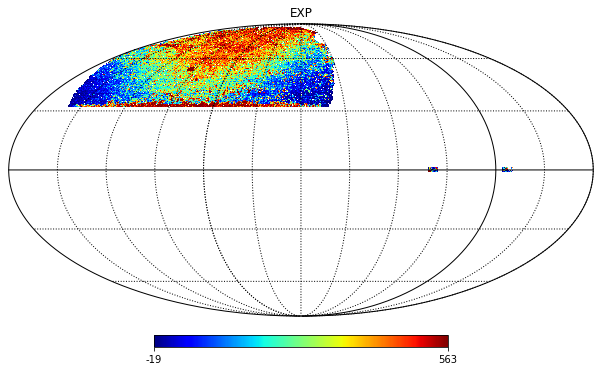

In [60]:
m_EXP = np.zeros(NPIX)

m_EXP[df_north.pixel_id.to_numpy()] = df_north.exposures.to_numpy()
mask = (m_EXP == 0)
m_EXP[mask] = np.nan
hp.mollview(m_EXP, title="EXP", format='%i', norm='hist', cmap="jet", notext=False, rot=(120, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [61]:
df_north.head()

,pixel_id,lrg,elg,qso,exposures
0,104818,1,2,0,4
1,104823,1,1,1,1
2,104838,1,0,1,1
3,104839,1,1,0,4
4,104849,1,1,0,1


### 4. Importing the Systematics Values and Appending them to the df.


#### a. Stellar Density

In [62]:
df_stellar = pd.read_csv('../../../bricks_data/stellar_catalogue_north.csv')


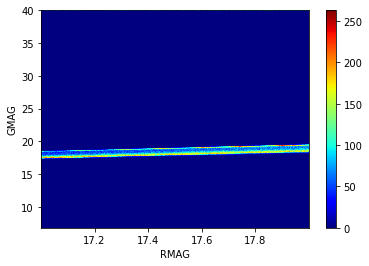

In [63]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [64]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(3831097, 5)


In [65]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [66]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30)]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4)]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4)]
print(df_stellar.shape)


(3464029, 7)


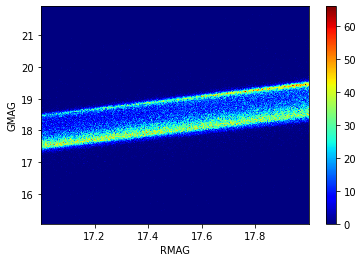

In [67]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()


In [68]:
#Dividing RMAG Column into 1000 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


927    3478
963    3477
921    3477
407    3476
774    3476
       ... 
775    3453
704    3453
408    3452
349    3452
928    3450
Name: percent_RMAG, Length: 1000, dtype: int64

In [69]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [70]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(3464029, 12)

In [71]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [72]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [73]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(3464029, 12)
(3436156, 12)


(3414224, 12)

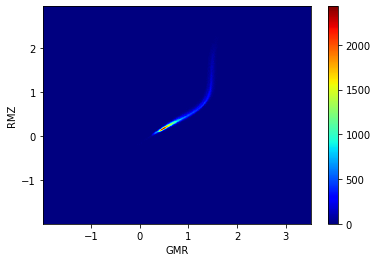

In [74]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [75]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta, phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 3414224
[  104852   104856   104926 ... 25849774 25850699 25850783]
Mean stellars per Pixel: 1.5310064518674902
[[  104852        1]
 [  104856        1]
 [  104926        1]
 ...
 [25849774        1]
 [25850699        1]
 [25850783        1]]
   pixel_id  stellar
0    104852        1
1    104856        1
2    104926        1
3    104929        1
4    104930        1
pixel_id    0
stellar     0
dtype: int64


In [76]:
df_north = df_north.merge(df_stellar, how='outer', on='pixel_id')

print(df_north.isna().sum())

df_north.fillna(axis=0, value=0, inplace=True)

df_north.shape

pixel_id           0
lrg            38690
elg            38690
qso            38690
exposures      38690
stellar      4045640
dtype: int64


(6275692, 6)

In [77]:
df_north.head()

,pixel_id,lrg,elg,qso,exposures,stellar
0,104818,1.0,2.0,0.0,4.0,0.0
1,104823,1.0,1.0,1.0,1.0,0.0
2,104838,1.0,0.0,1.0,1.0,0.0
3,104839,1.0,1.0,0.0,4.0,0.0
4,104849,1.0,1.0,0.0,1.0,0.0


0.0 180.0 -180.0 180.0


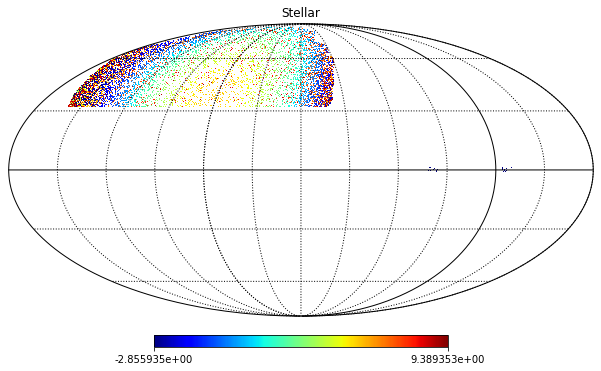

In [78]:
m_Stellar = np.zeros(NPIX)

m_Stellar[df_north.pixel_id.to_numpy()] = df_north.stellar.to_numpy()
mask = (m_Stellar == 0)
m_Stellar[mask] = np.nan
hp.mollview(m_Stellar, title="Stellar", format='%e', norm='hist', cmap="jet", notext=False, rot=(120, 0, 0),
            badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()


#### EBV Extraction

In [79]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery

In [80]:
from dustmaps.config import config

config['data_dir'] = '/Users/edgareggert/astrostatistics/data_preprocessing/.dustmapsrc'

In [81]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df_north["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE, pixels_ids, lonlat=True)
ra_ebv = subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  104818   104823   104838 ... 25849660 25850699 25850783]


In [82]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df_north["EBV"] = ebv

In [83]:
df_north.EBV.describe()
df_north.head()


,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,104818,1.0,2.0,0.0,4.0,0.0,0.141311
1,104823,1.0,1.0,1.0,1.0,0.0,0.161026
2,104838,1.0,0.0,1.0,1.0,0.0,0.235266
3,104839,1.0,1.0,0.0,4.0,0.0,0.232941
4,104849,1.0,1.0,0.0,1.0,0.0,0.179781


0.0 180.0 -180.0 180.0


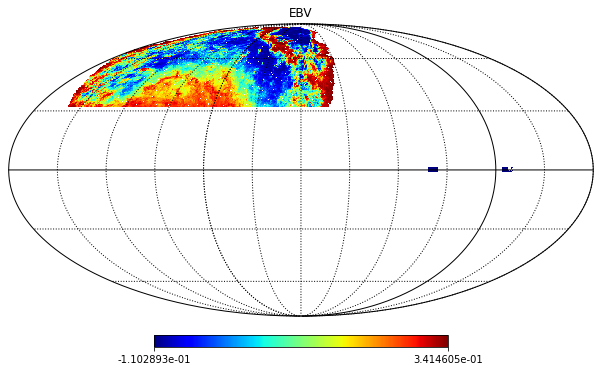

In [84]:
m_EBV = np.zeros(NPIX)

m_EBV[df_north.pixel_id.to_numpy()] = df_north.EBV.to_numpy()
mask = (m_EBV == 0)
m_EBV[mask] = np.nan
hp.mollview(m_EBV, title="EBV", format='%e', norm='hist', cmap="jet", notext=False, rot=(120, 0, 0), badcolor='white',
            remove_dip=True, remove_mono=True)
hp.graticule()

In [88]:
df_north.exposures = df_north.exposures.astype(int)
df_north.lrg = df_north.lrg.astype(int)
df_north.elg = df_north.elg.astype(int)
df_north.qso = df_north.qso.astype(int)
df_north.stellar = df_north.stellar.astype(int)

df_north.head()



,pixel_id,lrg,elg,qso,exposures,stellar,EBV
0,104818,1,2,0,4,0,0.141311
1,104823,1,1,1,1,0,0.161026
2,104838,1,0,1,1,0,0.235266
3,104839,1,1,0,4,0,0.232941
4,104849,1,1,0,1,0,0.179781


### ToDo: Need to add all the averaged statistics --> adapt systematics scripts to obtain these


### ToDo: Ask Boris about cleaning:

1. Which areas to exclude
2. Pixels with too few exposures, stars, galaxies?
3. Which features to extract?
    - Stellar, EBV, Airmass, Seeing (3), Surface Brightness (3), Exptime (3), Meansky (3) (Remove?)
    - GalDepth (3), PSFdepths (3), psfnorm_mean (3), gausspsfdepth (3), MJD, humitiy --> could be added

In [86]:
len(df_north)

6275692

In [87]:
NPIX

50331648